# Numerical solution of the Taylor Green Vortex using PINN 
# Governing equations
$\partial_x u + \partial_y v = 0 $

$\partial_t u + u\partial_x u + v\partial_y u = \frac{-\partial_x P}{\rho} + \mu(\partial_{xx}u+\partial_{yy}u)$

$\partial_t v + u\partial_x v + v\partial_y v = \frac{-\partial_y P}{\rho} + \mu(\partial_{xx}v+\partial_{yy}v)$

# Solutions over the domain $[0,2\pi]\times[0,2\pi]\times[0,T]$
$u = \cos(x)\sin(y)F(t)$

$v = -\sin(x)\cos(y)F(t)$

$P = -\frac{\rho}{4}(\cos(2x)+\cos(2y))F^2(t)$

Where, $F(t) = e^{-2\mu t}$

## Bibliography
### Physics Informed RNN-DCT Networks for Time-Dependent Partial Differential Equations. Authors: Benjamin Wu, Oliver Hennigh, Jan Kautz, Sanjay Choudhry and Wonmin Byeon.

# Libraries

In [10]:
import jax, optax
import pickle
import functools
import matplotlib.pyplot, matplotlib.animation
import numpy
%matplotlib inline

# Set and verify device
jax.config.update('jax_platform_name', 'gpu')
jax.config.update("jax_enable_x64", True)
print(jax.lib.xla_bridge.get_backend().platform)

gpu


# Parameters

In [11]:
# Neural network parameters
parameters = {}
parameters['seed'] = 351
parameters['n_features'] = 3         # Input dimension (x1, x2)
parameters['n_targets'] = 3          # Output dimension. We solve a system of equations (u, v, p)
parameters['hidden_layers'] = [50, 50, 50, 50, 50]   # Hidden layers structure
parameters['layers'] = [parameters['n_features']] + parameters['hidden_layers'] + [parameters['n_targets']]

# Training parameters
parameters['learning_rate'] = optax.linear_schedule(0.005, 0.00001, transition_steps = 50, transition_begin = 5000)
parameters['optimizer'] = optax.adam(parameters['learning_rate'])
parameters['maximum_num_epochs'] = 50000
parameters['report_steps'] = 1000
parameters['options'] = 1            # 1: we start a new training. 2: We continue the last training. 
                                     # Other cases: We just load the last training

# Data parameters
parameters['n_inside'] = 4096        # number of points inside the domain
parameters['n_bound'] = 500          # number of points at the boundary
parameters['domain_bounds'] = jax.numpy.column_stack(([0, 0, 0], [2*jax.numpy.pi, 2*jax.numpy.pi, 2*jax.numpy.pi]))        # minimal and maximal value of each axis (x,y,t)


# Neural network

In [12]:
class MLP:
    """
        Create a multilayer perceptron and initialize the neural network
    Inputs :
        A SEED number and the layers structure
    """
    def __init__(self, key, layers):
        self.key = key
        self.keys = jax.random.split(self.key,len(layers))
        self.layers = layers
        self.params = []

    def MLP_create(self):
        """
        Initialize the MLP weigths and bias
        Parameters
        ----------
        Returns
        -------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        """
        for layer in range(0, len(self.layers)-1):
            in_size,out_size = self.layers[layer], self.layers[layer+1]
            weights = jax.nn.initializers.glorot_normal()(self.keys[layer], (out_size, in_size), jax.numpy.float32)
            bias = jax.nn.initializers.lecun_normal()(self.keys[layer], (out_size, 1), jax.numpy.float32).reshape((out_size, ))
            self.params.append((weights, bias))
        return self.params
        

    @functools.partial(jax.jit, static_argnums=(0,))    
    def NN_evaluation(self, params, inputs):
        """
        Evaluate a position XY using the neural network    
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size]]
            -- points in the mesh
        Returns
        -------
        output : jax.numpy.array[batch_size]
            -- output of the neural network 
        """
        for layer in range(0, len(params)-1):
            weights, bias = params[layer]
            inputs = jax.nn.tanh(jax.numpy.add(jax.numpy.dot(inputs, weights.T), bias))
        weights, bias = params[-1]
        output = jax.numpy.dot(inputs, weights.T)+bias

        return output

# Operators

In [13]:
class PDE_operators:
    """
        Class with the most common operators used to solve PDEs
    Input:
        A function that we want to compute the respective operator
    """
    def __init__(self, function):
        self.function = function


    @functools.partial(jax.jit, static_argnums=(0,))    
    def laplacian2d(self, params, inputs):
        """
        Compute the two dimensional laplacian. Laplacian of u and v
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        laplacian : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the laplacian applied to the inputs
        """
        @functools.partial(jax.jit)    
        def laplacian(params, inputs, output):            # Compute the laplacian of output (u or v)
            fun = lambda params, x, y, t: self.function(params, x, y, t)[:,output]

            @functools.partial(jax.jit)    
            def action(params, x, y, t):               # function to vectorize the laplacian
                a_xx = jax.jacfwd(jax.jacfwd(fun, 1), 1)(params, x, y, t)
                a_yy = jax.jacfwd(jax.jacfwd(fun, 2), 2)(params, x, y, t)
                return a_xx + a_yy

            vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0))
            lap = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2])
            return lap

        lapu = laplacian(params,inputs,0)       # laplacian for u
        lapv = laplacian(params,inputs,1)       # laplacian for v
        lapu_lapv = jax.numpy.column_stack((lapu,lapv))

        return lapu_lapv


    @functools.partial(jax.jit, static_argnums=(0,))    
    def pression_gradient(self, params, inputs):
        """
        Compute the gradient of the pression
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        gradient : jax.numpy.ndarray[[batch_size,batch_size]]
            -- numerical values of the gradient applied to the inputs
        """

        fun = lambda params, x, y, t: self.function(params, x, y, t)[:,2]

        @functools.partial(jax.jit)    
        def action(params, x, y, t):               # function to vectorize the laplacian
            p_x = jax.jacfwd(fun, 1)(params, x, y, t)
            p_y = jax.jacfwd(fun, 2)(params, x, y, t)
            return jax.numpy.column_stack((p_x, p_y))

        vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0))
        gradient = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2])
        gradient = gradient.reshape((gradient.shape[0], gradient.shape[2]))

        return gradient


    @functools.partial(jax.jit, static_argnums=(0,))    
    def speed_divergent(self, params, inputs):
        """
        Compute the divergent of (u,v)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        divergent : jax.numpy.array[batch_size]
            -- numerical values of the divergent of (u,v) applied to the inputs
        """

        funu = lambda params, x, y, t: self.function(params, x, y, t)[:,0] 
        funv = lambda params, x, y, t: self.function(params, x, y, t)[:,1] 

        @functools.partial(jax.jit)    
        def actionu(params, x, y, t):              # function to vectorize the laplacian
            u_x = jax.jacfwd(funu, 1)(params, x, y, t)
            return u_x

        @functools.partial(jax.jit)    
        def actionv(params, x, y, t):              # function to vectorize the laplacian
            v_y = jax.jacfwd(funv, 2)(params, x, y, t)
            return v_y

        vec_fun = jax.vmap(actionu, in_axes = (None, 0, 0, 0))
        du_dx =  vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2])

        vec_fun = jax.vmap(actionv, in_axes = (None, 0, 0, 0))
        dv_dy =  vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2])

        divergent = du_dx + dv_dy
        divergent = divergent.reshape(-1,)

        return divergent


    @functools.partial(jax.jit, static_argnums=(0,))    
    def material_derivative(self, params, inputs):
        """
        Compute the material derivative of u and v
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size,batch_size,batch_size]]
            -- coordinates and time  (x,y,t)
        Returns
        -------
        mat_derivative : jax.numpy.ndarray[[batch_size, batch_size]]
            -- numerical values of the material derivative of (u,v) applied to the inputs
        """

        result = self.function(params, inputs[:,0], inputs[:,1], inputs[:,2])

        @functools.partial(jax.jit)    
        def all_derivatives(params, inputs, output):      # compute all derivatives of output (u or v)
            fun = lambda params, x, y, t: self.function(params, x, y, t)[:,output]

            @functools.partial(jax.jit)    
            def action(params, x, y, t):                   # function to vectorize the laplacian
                a_x = jax.jacfwd(fun, 1)(params, x, y, t)
                a_y = jax.jacfwd(fun, 2)(params, x, y, t)
                a_t = jax.jacfwd(fun, 3)(params, x, y, t)
                return jax.numpy.column_stack((a_x, a_y, a_t))

            vec_fun = jax.vmap(action, in_axes = (None, 0, 0, 0))
            values = vec_fun(params, inputs[:,0], inputs[:,1], inputs[:,2])

            return values.reshape((values.shape[0], values.shape[2]))

        vector = jax.numpy.column_stack((result[:,0], result[:,1], jax.numpy.ones_like(result[:,0])))

        all_first_derivatives_u = all_derivatives(params, inputs, 0)
        mat_derivative_u = jax.numpy.einsum('ij,ij->i', all_first_derivatives_u, vector)

        all_first_derivatives_v = all_derivatives(params, inputs, 1)
        mat_derivative_v = jax.numpy.einsum('ij,ij->i', all_first_derivatives_v, vector)

        mat_derivative = jax.numpy.column_stack((mat_derivative_u, mat_derivative_v))

        return mat_derivative

# Physics Informed Neural Network

In [14]:
class PINN:
    """
    Solve a PDE using Physics Informed Neural Networks   
    Input:
        The evaluation function of the neural network
    """
    def __init__(self, NN_evaluation, optimizer):
        self.NN_evaluation = NN_evaluation
        self.optimizer = optimizer
        self.density = 1
        self.viscosity = 0.1

        self.operators = PDE_operators(self.solution)
        self.pression_gradient = self.operators.pression_gradient
        self.speed_divergent = self.operators.speed_divergent
        self.material_derivative = self.operators.material_derivative
        self.laplacian = self.operators.laplacian2d


    @functools.partial(jax.jit, static_argnums=(0,))    
    def solution(self, params, inputX, inputY, inputT):
        """
        Compute the solution of the PDE on the points (x,y,t)
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputX : jax.numpy.array[batch_size]
            -- points on the x-axis of the mesh
        inputY : jax.numpy.array[batch_size]
            -- points on the y-axis of the mesh
        inputT : jax.numpy.array[batch_size]
            -- points on the time-axis
        Returns
        -------
        applied_solution : jax.numpy.ndarray[batch_size,batch_size,batch_size]
            -- PINN solution applied to inputs. return (u,v,p)
        """

        inputs = jax.numpy.column_stack((inputX, inputY, inputT))
        NN = jax.vmap(functools.partial(jax.jit(self.NN_evaluation), params))(inputs)

        return NN


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_boundary(self, params, inputs):      
        """
        Compute the loss function at the boundary
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        bound : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from boundary
        Returns
        -------
        loss_bound : a float.64
            -- loss function applied to inputs
        """

        exact_bound = jax.numpy.column_stack((jax.numpy.cos(inputs[:,0])*jax.numpy.sin(inputs[:,1])*jax.numpy.exp(-2*self.viscosity*inputs[:,2]), -jax.numpy.cos(inputs[:,1])*jax.numpy.sin(inputs[:,0])*jax.numpy.exp(-2*self.viscosity*inputs[:,2]), -self.density/4*(jax.numpy.cos(2*inputs[:,0]) + jax.numpy.cos(2*inputs[:,1]))*jax.numpy.exp(-2*self.viscosity*inputs[:,2])**2))
        preds_bound = self.solution(params, inputs[:,0], inputs[:,1], inputs[:,2])
        loss_bound = jax.numpy.sum(jax.numpy.mean((preds_bound - exact_bound)**2))

        return loss_bound


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_residual_pde(self, params, inputs):
        """
        Compute the residual of the pde
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from the mesh
        Returns
        -------
        loss_residual : a float.64
            -- loss function applied to inputs
        """

        loss_continuity = jax.numpy.sum(jax.numpy.mean(self.speed_divergent(params, inputs)**2))
        preds_momentum = self.material_derivative(params, inputs) + self.pression_gradient(params, inputs)/self.density - self.laplacian(params, inputs)*self.viscosity
        loss_momentum = jax.numpy.sum(jax.numpy.mean(preds_momentum**2))
        loss_residual = loss_momentum + loss_continuity

        return loss_residual


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_initial_time(self, params, inputs):      
        """
        Compute the loss function at the initial conditions
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inputs : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss_initial : a float.64
            -- loss function applied to inputs
        """

        preds_initial = self.solution(params, inputs[:,0], inputs[:,1], inputs[:,2])
        exact_initial = jax.numpy.column_stack((jax.numpy.cos(inputs[:,0])*jax.numpy.sin(inputs[:,1]), -jax.numpy.sin(inputs[:,0])*jax.numpy.cos(inputs[:,1]), -self.density*(jax.numpy.cos(2*inputs[:,0]) + jax.numpy.cos(2*inputs[:,1]))/4))
        loss_initial = jax.numpy.sum(jax.numpy.mean((preds_initial - exact_initial)**2))

        return loss_initial


    @functools.partial(jax.jit, static_argnums=(0,))    
    def loss_function(self, params, inside, bound, initial):
        """
        Compute the sum of each loss function
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        losses : numpy.array(loss_residual, loss_b, loss_i)
            -- current values of each loss function
        """

        loss_bound = self.loss_boundary(params, bound)
        loss_initial = self.loss_initial_time(params, initial)
        loss_residual = self.loss_residual_pde(params, inside)
        loss_sum = loss_bound+loss_initial+loss_residual
        losses = jax.numpy.array([loss_residual, loss_bound, loss_initial])

        return loss_sum, losses


    @functools.partial(jax.jit, static_argnums=(0,))    
    def train_step(self, params, opt_state, inside, bound, initial):
        """
        Make just one step of the training
        Parameters
        ----------
        params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias
        opt_state : a tuple given by optax
            -- state(hystorical) of the gradient descent
        inside : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from the mesh
        bound : jax.numpy.ndarray[[batch_size, batch_size,batch_size]]
            -- (x,y,t) points from boundary
        initial : jax.numpy.ndarray[[batch_size, batch_size, batch_size]]
            -- (x,y,t) points from initial condition
        Returns
        -------
        loss : a float.64
            -- loss function applied to inputs
        new_params : list of parameters[[w1,b1],...,[wn,bn]]
            -- weights and bias updated
        opt_state : a tuple given by optax
            -- update the state(hystorical) of the gradient descent
        losses : dictionary with the keys (loss_m, loss_b, loss_i)
            -- current values of each loss function
        """

        (loss,losses), gradient = jax.value_and_grad(self.loss_function, has_aux=True)(params, inside, bound, initial)
        updates, new_opt_state = self.optimizer.update(gradient, opt_state)
        new_params = optax.apply_updates(params, updates)

        return loss, new_params, new_opt_state, losses

# 2D dataset creation

In [15]:
#### Boundary data
X, Y = jax.numpy.meshgrid(jax.numpy.linspace(parameters['domain_bounds'][0,0],parameters['domain_bounds'][0,1],parameters['n_bound']//4),jax.numpy.linspace(parameters['domain_bounds'][1,0],parameters['domain_bounds'][1,1],2))

X, Y = X.flatten(), Y.flatten()
left_right = jax.numpy.column_stack((X,Y))
front_behind = jax.numpy.column_stack((Y,X))
XY_bound = jax.numpy.concatenate((left_right,front_behind))
XY_bound = jax.numpy.column_stack((XY_bound[:,0],XY_bound[:,1]))

#### Inside data
ran_key, batch_key = jax.random.split(jax.random.PRNGKey(0))
XY_inside = jax.random.uniform(batch_key, shape=(parameters['n_inside'], parameters['n_features']-1), minval=parameters['domain_bounds'][:2,0], maxval=parameters['domain_bounds'][:2,1])


# 2D dataset plot

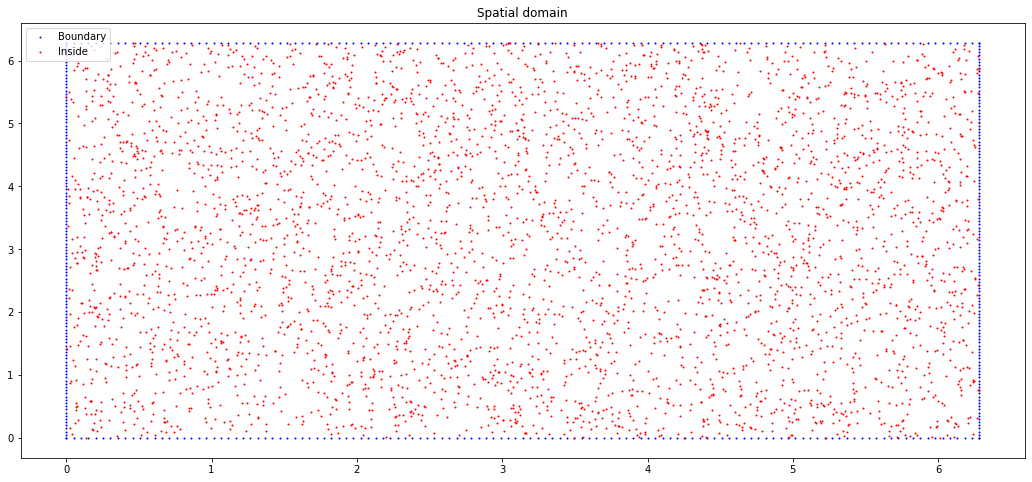

In [16]:
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(18, 8.0)
title = ax.set_title('Spatial domain')
graph = matplotlib.pyplot.scatter(XY_bound[:,0],XY_bound[:,1],color='b',s=1)
graph = matplotlib.pyplot.scatter(XY_inside[:,0],XY_inside[:,1],color='r',s=1)
__ = ax.legend(['Boundary','Inside'])
matplotlib.pyplot.savefig('./Images/domain.png', bbox_inches = 'tight', facecolor='white')
matplotlib.pyplot.show()  


# Model initialization

In [17]:
key = jax.random.PRNGKey(parameters['seed'])
NN_MLP = MLP(key, parameters['layers'])                 
params = NN_MLP.MLP_create()            # Create the MLP
NN_eval = NN_MLP.NN_evaluation            # Evaluate function
solver = PINN(NN_eval, parameters['optimizer'])
opt_state = parameters['optimizer'].init(params)

# Training

In [18]:
print("Training start")
if parameters['options'] == 1:            # begin a new training
    loss_history = []
    loss_residual = []               # residual loss
    loss_boundary = []               # boundary loss
    loss_initial_cond = []           # boundary initial condition

    # Main loop to solve the PDE
    for ibatch in range(parameters['maximum_num_epochs']+1):
        XYT_bound = jax.numpy.column_stack((XY_bound[:,0],XY_bound[:,1],numpy.random.uniform(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,1],size=(parameters['n_bound'],))))
        XYT_inside = jax.numpy.column_stack((XY_inside[:,0],XY_inside[:,1],numpy.random.uniform(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,1],size=(parameters['n_inside'],))))
        XYT_initial = jax.numpy.column_stack((XY_inside[:,0],XY_inside[:,1],jax.numpy.zeros(parameters['n_inside'])))

        loss, params, opt_state, losses = solver.train_step(params,opt_state, XYT_inside, XYT_bound, XYT_initial)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        loss_initial_cond.append(float(losses[2]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_vortex", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_vortex", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_vortex", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_vortex", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_vortex", "wb"))
            pickle.dump(loss_initial_cond, open("./Checkpoints/loss_initial_cond_vortex", "wb"))

elif parameters['options'] == 2:      # continue the last training
    params = pickle.load(open("./Checkpoints/params_checkpoint_vortex", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_vortex", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_vortex", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_vortex", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_vortex", "rb"))
    loss_initial_cond = pickle.load(open("./Checkpoints/loss_initial_cond_vortex", "rb"))
    iepoch = len(loss_history)
    
    # Main loop to solve the PDE
    for ibatch in range(iepoch,parameters['maximum_num_epochs']+1):
        XYT_bound = jax.numpy.column_stack((XY_bound[:,0],XY_bound[:,1],numpy.random.uniform(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,1],size=(parameters['n_bound'],))))
        XYT_inside = jax.numpy.column_stack((XY_inside[:,0],XY_inside[:,1],numpy.random.uniform(parameters['domain_bounds'][2,0],parameters['domain_bounds'][2,1],size=(parameters['n_inside'],))))
        XYT_initial = jax.numpy.column_stack((XY_inside[:,0],XY_inside[:,1],jax.numpy.zeros(parameters['n_inside'])))
        
        loss, params, opt_state, losses = solver.train_step(params,opt_state, XYT_inside, XYT_bound, XYT_initial)

        loss_residual.append(float(losses[0]))
        loss_boundary.append(float(losses[1]))
        loss_initial_cond.append(float(losses[2]))
        losssum = jax.numpy.sum(losses)
        loss_history.append(float(losssum))

        if ibatch%parameters['report_steps']==parameters['report_steps']-1:
            print("Epoch n°{}: ".format(ibatch+1), losssum.item())

        if losssum<=numpy.min(loss_history): # save if the current state is the best 
            pickle.dump(params, open("./Checkpoints/params_checkpoint_vortex", "wb"))
            pickle.dump(opt_state, open("./Checkpoints/opt_state_checkpoint_vortex", "wb"))
            pickle.dump(loss_history, open("./Checkpoints/loss_history_vortex", "wb"))
            pickle.dump(loss_residual, open("./Checkpoints/loss_residual_vortex", "wb"))
            pickle.dump(loss_boundary, open("./Checkpoints/loss_boundary_vortex", "wb"))
            pickle.dump(loss_initial_cond, open("./Checkpoints/loss_initial_cond_vortex", "wb"))

else:
    params = pickle.load(open("./Checkpoints/params_checkpoint_vortex", "rb"))
    opt_state = pickle.load(open("./Checkpoints/opt_state_checkpoint_vortex", "rb"))
    loss_history = pickle.load(open("./Checkpoints/loss_history_vortex", "rb"))
    loss_residual = pickle.load(open("./Checkpoints/loss_residual_vortex", "rb"))
    loss_boundary = pickle.load(open("./Checkpoints/loss_boundary_vortex", "rb"))
    loss_initial_cond = pickle.load(open("./Checkpoints/loss_initial_cond_vortex", "rb"))

Training start
Epoch n°1000:  0.0013684931414270525
Epoch n°2000:  0.00031105154576537914
Epoch n°3000:  0.00019688680533154614
Epoch n°4000:  0.0008150989607141018
Epoch n°5000:  0.00045528441000916673
Epoch n°6000:  7.141405294665161e-05
Epoch n°7000:  7.456593872922338e-05
Epoch n°8000:  7.213827632705236e-05
Epoch n°9000:  6.65980327832148e-05
Epoch n°10000:  6.899303830987708e-05
Epoch n°11000:  6.515998318225717e-05
Epoch n°12000:  5.942333730947754e-05
Epoch n°13000:  5.352281499364529e-05
Epoch n°14000:  5.1599167641746315e-05
Epoch n°15000:  4.606004399137578e-05
Epoch n°16000:  3.9958665905437744e-05
Epoch n°17000:  3.641156080817452e-05
Epoch n°18000:  3.481556371173801e-05
Epoch n°19000:  3.413931963028064e-05
Epoch n°20000:  3.123545828707273e-05
Epoch n°21000:  2.734478893624094e-05
Epoch n°22000:  2.5880070535226998e-05
Epoch n°23000:  2.4841676658991966e-05
Epoch n°24000:  2.4264476945345204e-05
Epoch n°25000:  2.407752738143763e-05
Epoch n°26000:  2.264596305399665e-05

# Loss function

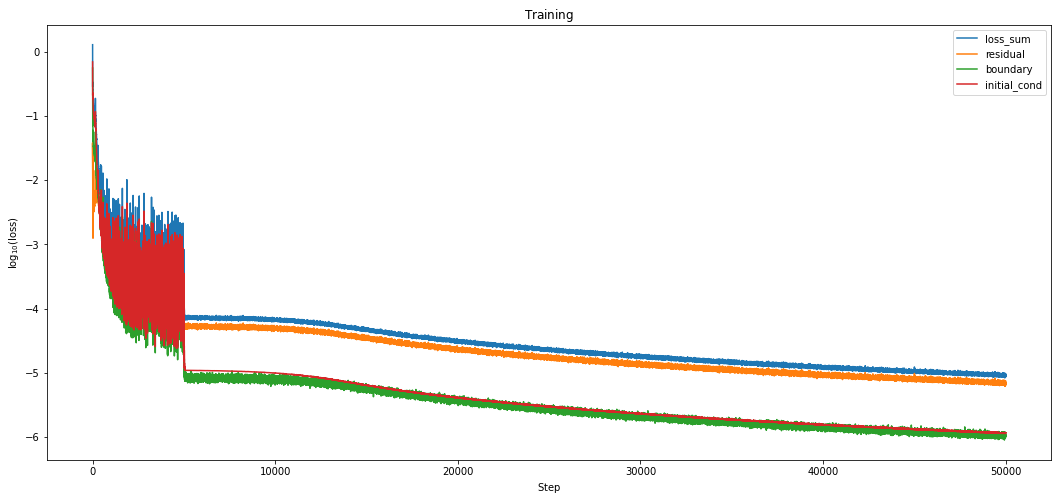

In [19]:
fig, ax = matplotlib.pyplot.subplots(1, 1)
fig.set_size_inches(18, 8.0)
__ = ax.plot(numpy.log10(loss_history))
__ = ax.plot(numpy.log10(numpy.array(loss_residual)))
__ = ax.plot(numpy.log10(numpy.array(loss_boundary)))
__ = ax.plot(numpy.log10(numpy.array(loss_initial_cond)))
xlabel = ax.set_xlabel(r'${\rm Step}$')
ylabel = ax.set_ylabel(r'$\log_{10}{\rm (loss)}$')
title = ax.set_title(r'${\rm Training}$')
ax.legend(['loss_sum','residual','boundary','initial_cond'])
matplotlib.pyplot.savefig('./Images/loss_function.png', bbox_inches = 'tight', facecolor='white')
matplotlib.pyplot.show()

# True solution

In [20]:
def analytical_solution(x,y,t, viscosity = 0.1, density = 1):
    """
    Compute the analytical solution on the domain
    Parameters
    ----------
    x : jax.numpy.ndarray[batch_size]
        -- points in the axis x
    y : jax.numpy.ndarray[batch_size]
        -- points in the axis y
    t : jax.numpy.ndarray[batch_size]
        -- time points
    Returns
    -------
    sol : jax.numpy.ndarray[batch_size]
        -- analytical solution applied to inputs
    """
    u = jax.numpy.cos(x)*jax.numpy.sin(y)*jax.numpy.exp(-2*viscosity*t)
    v = -jax.numpy.sin(x)*jax.numpy.cos(y)*jax.numpy.exp(-2*viscosity*t)
    p = -density/4*(jax.numpy.cos(2*x) + jax.numpy.cos(2*y))*jax.numpy.exp(-2*viscosity*t)**2
    sol = jax.numpy.column_stack((u, v, p))

    return sol

# Mean squared error

In [21]:
params = pickle.load(open("./Checkpoints/params_checkpoint_vortex", "rb"))
ran_key, batch_key = jax.random.split(jax.random.PRNGKey(1178))
XYT_test = jax.random.uniform(batch_key, shape=(10000, parameters['n_features']), minval=parameters['domain_bounds'][2,0], maxval=parameters['domain_bounds'][2,1])
x, y, t = XYT_test[:,0], XYT_test[:,1], XYT_test[:,2]
mean_error = numpy.mean(((analytical_solution(x, y, t) - solver.solution(params,x, y, t)))**2, axis=0)
print('mean squared error u: ', mean_error[0],'\nmean squared error v: ',mean_error[1],'\nmean squared error p: ',mean_error[2])

mean squared error u:  5.743879870381111e-07 
mean squared error v:  6.447241447709193e-07 
mean squared error p:  9.003536065142443e-07


# Solution in u

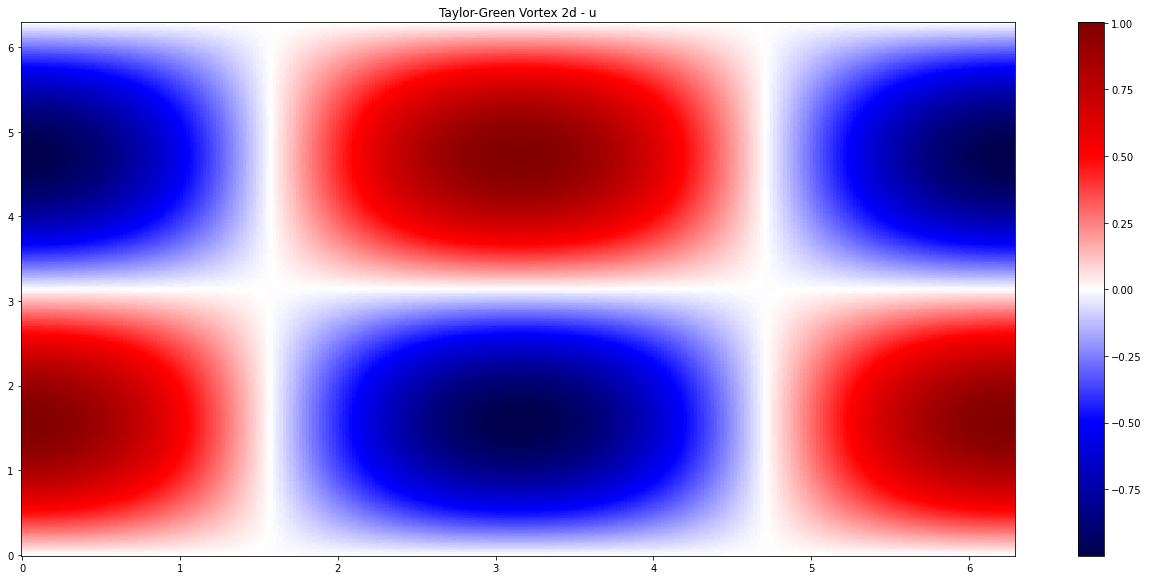

In [22]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = solver.solution(params, x[i,:], y[i,:], t[num,:])[:,0]
    title.set_text('Taylor-Green Vortex 2d - u, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - u')

for i in range(npoints):
    values[i,:] = solver.solution(params, x[i,:], y[i,:], t[0,:])[:,0]

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'seismic')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/taylor_green_vortex_u.gif', writer='pillow', fps = 10)


# Squared error in u

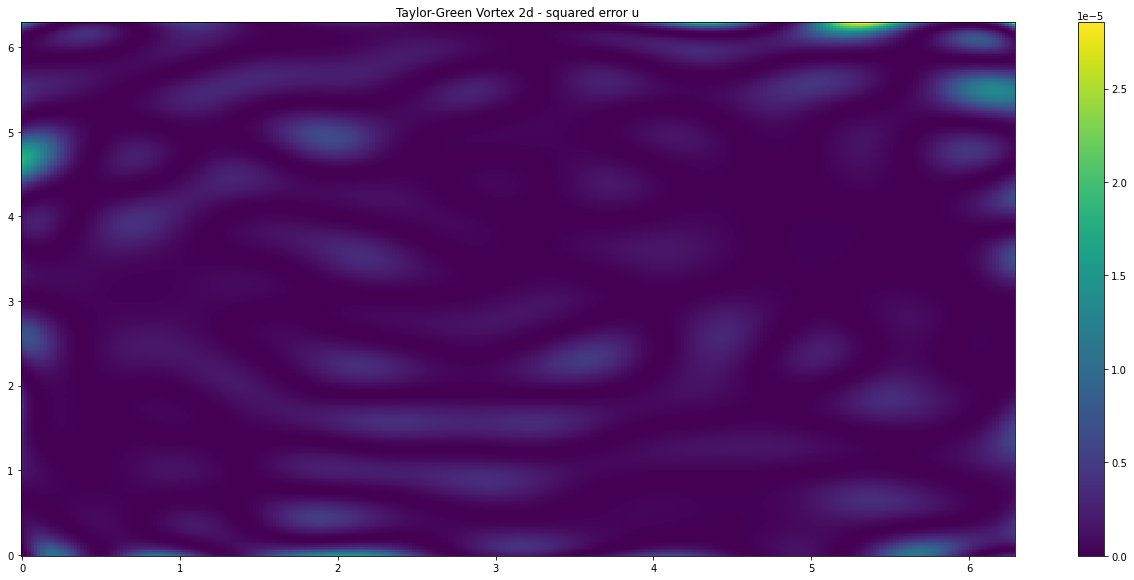

In [23]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[num,:])[:,0]-solver.solution(params, x[i,:], y[i,:], t[num,:])[:,0]))**2
    title.set_text('Taylor-Green Vortex 2d - squared error u, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - squared error u')

for i in range(npoints):
    values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[0,:])[:,0]-solver.solution(params, x[i,:], y[i,:], t[0,:])[:,0]))**2

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'viridis')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/squared_error_u.gif', writer='pillow', fps = 10)

# Solution in v

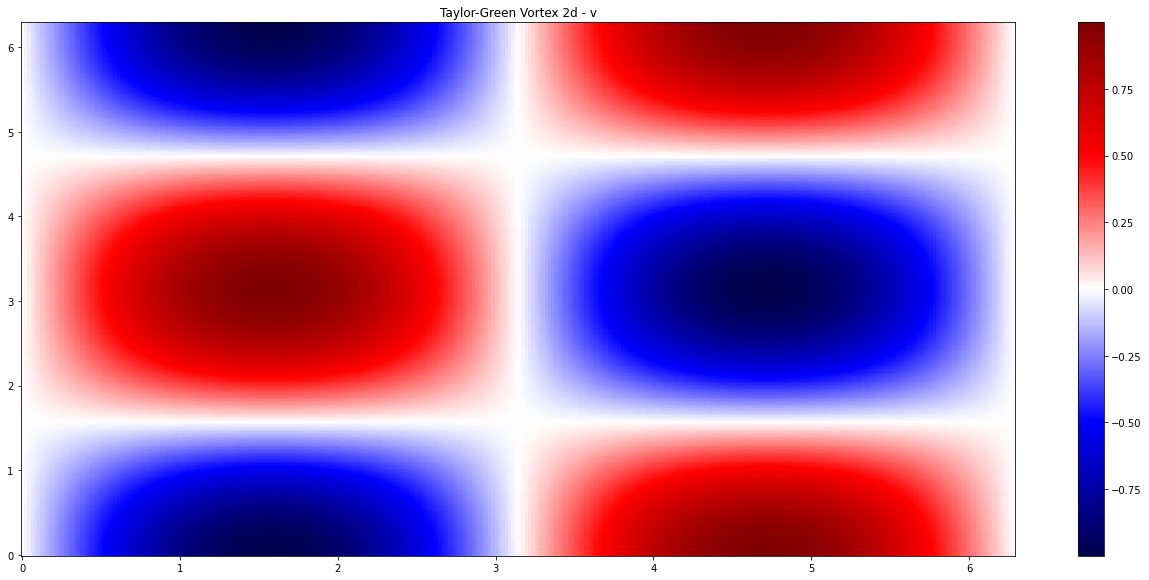

In [24]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = solver.solution(params, x[i,:], y[i,:], t[num,:])[:,1]
    title.set_text('Taylor-Green Vortex 2d - v, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - v')

for i in range(npoints):
    values[i,:] = solver.solution(params, x[i,:], y[i,:], t[0,:])[:,1]

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'seismic')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/taylor_green_vortex_v.gif', writer='pillow', fps = 10)

# Squared error in v

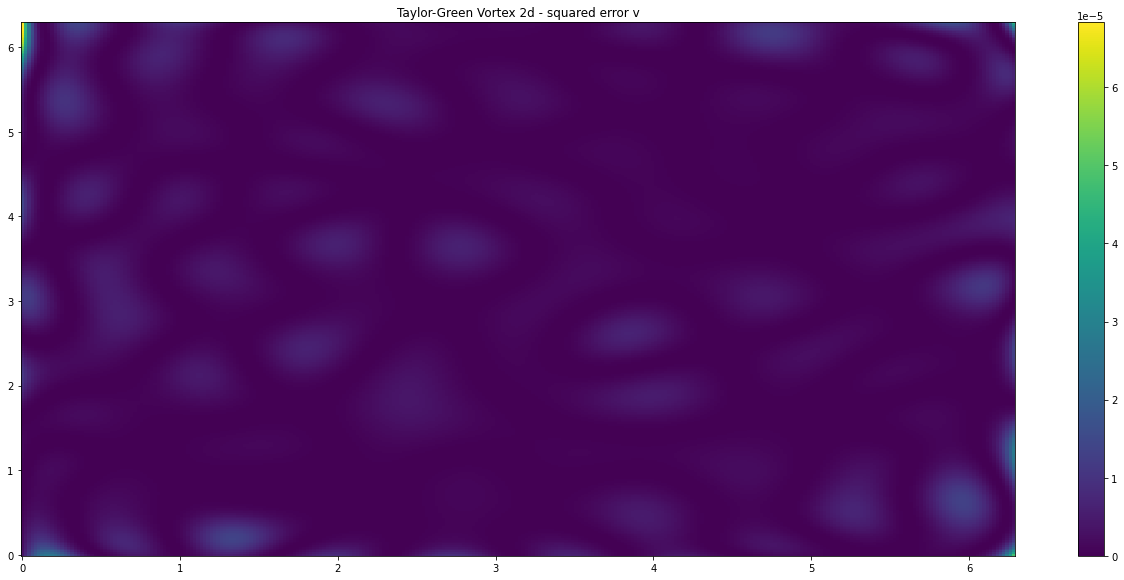

In [25]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[num,:])[:,1]-solver.solution(params, x[i,:], y[i,:], t[num,:])[:,1]))**2
    title.set_text('Taylor-Green Vortex 2d - squared error v, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - squared error v')

for i in range(npoints):
    values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[0,:])[:,1]-solver.solution(params, x[i,:], y[i,:], t[0,:])[:,1]))**2

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'viridis')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/squared_error_v.gif', writer='pillow', fps = 10)

# Solution in p

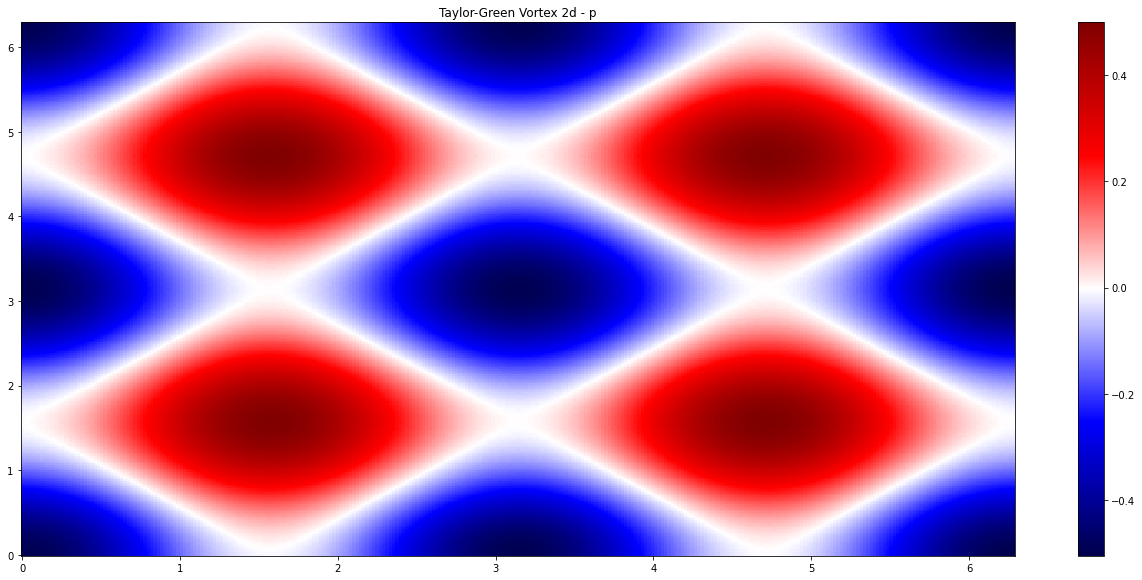

In [26]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = solver.solution(params, x[i,:], y[i,:], t[num,:])[:,2]
    title.set_text('Taylor-Green Vortex 2d - p, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - p')

for i in range(npoints):
    values[i,:] = solver.solution(params, x[i,:], y[i,:], t[0,:])[:,2]

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'seismic')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/taylor_green_vortex_p.gif', writer='pillow', fps = 10)

# Squared error in p

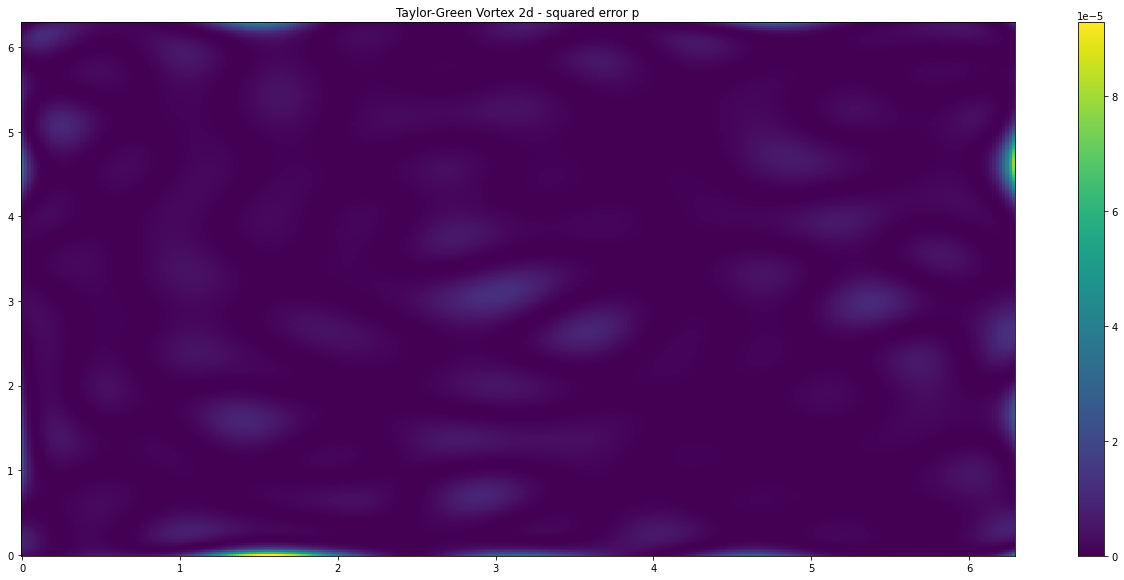

In [27]:
npoints = 300
frames = 100

x, y = numpy.meshgrid(numpy.linspace(parameters['domain_bounds'][0,0], parameters['domain_bounds'][0,1], npoints),numpy.linspace(parameters['domain_bounds'][1,0], parameters['domain_bounds'][1,1], npoints))
t = numpy.repeat(numpy.linspace(parameters['domain_bounds'][2,0], parameters['domain_bounds'][2,1], frames), npoints).reshape(frames, npoints)
values = numpy.zeros((npoints, npoints))

def update_graph(num):
    print("Animating: {} out of {}".format(num+1, frames), end='\r')
    for i in range(npoints):
        values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[num,:])[:,2]-solver.solution(params, x[i,:], y[i,:], t[num,:])[:,2]))**2
    title.set_text('Taylor-Green Vortex 2d - squared error p, time step = {}'.format(num))
    graph.set_array(values.flatten())

fig, ax = matplotlib.pyplot.subplots(facecolor='white')
fig.set_size_inches(18, 8.0)
fig.tight_layout(h_pad=3)
title = ax.set_title('Taylor-Green Vortex 2d - squared error p')

for i in range(npoints):
    values[i,:] = ((analytical_solution(x[i,:], y[i,:], t[0,:])[:,2]-solver.solution(params, x[i,:], y[i,:], t[0,:])[:,2]))**2

graph = matplotlib.pyplot.pcolormesh(x, y, values, cmap = 'viridis')
ani = matplotlib.animation.FuncAnimation(fig, update_graph, frames = frames, blit = False)
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()  
ani.save('./Images/squared_error_p.gif', writer='pillow', fps = 10)